# Multioutput Gaussian process example

## Usage notes
This toolkit works in the following order:- Set up the input data
- Create model (SM, MOSM, CSM, SM-LMC, CG)
- Make an estimation of the model parameters using BNSE+SM
- Train the model parameters
- Set the prediction range
- Do a prediction For example:

<div class="alert alert-block alert-warning">
<b>Example:</b> <br>
```
import mogptk

x, y = get_your_data()

data = mogptk.Data()
data.add(x, y)

mosm = mogptk.MOSM(data, Q=3)
mosm.init_params()
mosm.train()

mosm.set_prediction_range(0, 0.0, 5.0, n=200)
x_pred, mu_pred, var_pred = mosm.predict()
```
</div>

#### Imports and plot format

In [1]:
# execute if not installed
import sys
import os
sys.path.insert(0, '../')

import mogptk

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

%reload_ext autoreload
%autoreload 2

In [ ]:
mogptk.errors()

In [ ]:
mogptk.test_errors()

In [2]:
os.makedirs('output', exist_ok=True)

In [3]:
# plot config
sns.set_context('paper', font_scale=1.3)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

# Mauna Loa

Experiment of CO2 measurements in Mauna Loa, Hawaii, using single output Gaussian process with Spectral Mixture Kernel.

Data correspond to measurements on CO2 from 1958 to 2001, we resample the data and obtain averages to make 10 samples per year, then the yearly trend will be at frequency $1/10=0.1$

In [4]:
# dataset mauna loa
from sklearn.datasets import fetch_openml

# function to load dataset
def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs

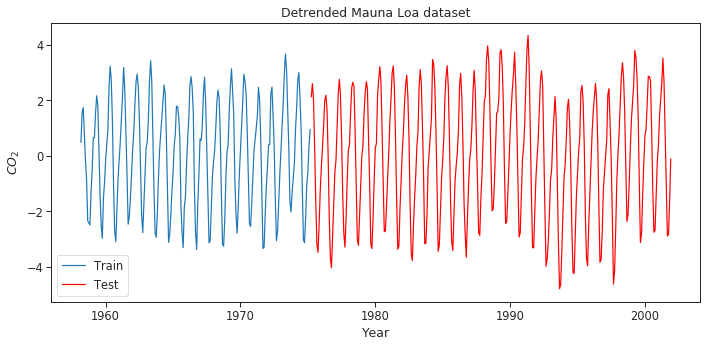

In [5]:
# load data
x, y_old = load_mauna_loa_atmospheric_co2()

# detrend 
poly = np.polyfit(x, y_old, 3)
y = y_old - np.polyval(poly, x)
trend = y_old - y

# point to separate train from test
stop = 200

# plot
plt.plot(x[:stop], y[:stop], label='Train')
plt.plot(x[stop:], y[stop:], 'r', label='Test')
plt.legend()
plt.xlabel('Year')
plt.ylabel(r'$CO_2$');
plt.title('Detrended Mauna Loa dataset')
plt.tight_layout();

__First, we initialize the model with random parameters, and show the spectral density of the kernel.
As we are only taking random values, there is no relation with the data.__

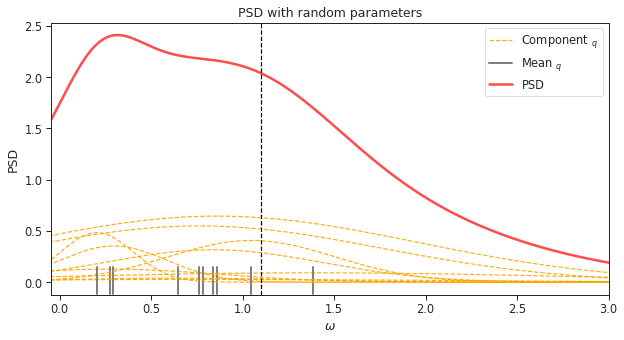

In [6]:
# add data
data = mogptk.Data()
data.add(x[:stop], y[:stop])

# create model
model = mogptk.SM(data, Q=10)

mogptk.plot_psd(model, title='PSD with random parameters')
plt.axvline(x=11/10, linestyle='--', c='k')
plt.xlim(-0.05, 3);

__Second we initialize the parameters before training, using Bayesian Nonparametric spectral estimation (BNSE) (Tobar 2017), and use the estimated Power spectral density (PSD) to define initial spectral mean and magnitudes.__

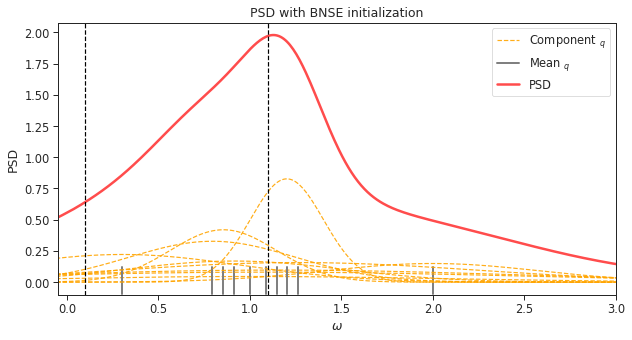

In [7]:
method = 'BNSE'
model.init_params(method)

mogptk.plot_psd(model, title='PSD with {} initialization'.format(method))
plt.axvline(x=1/10, linestyle='--', c='k')
plt.axvline(x=11/10, linestyle='--', c='k')
plt.xlim(-0.05, 3);

__Then we train the model, and show the power spectral density of the trained model__

Building...
Optimizing...
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 50.727235
  Number of iterations: 3000
  Number of functions evaluations: 3336
Done
CPU times: user 14.3 s, sys: 2.58 s, total: 16.9 s
Wall time: 13.6 s


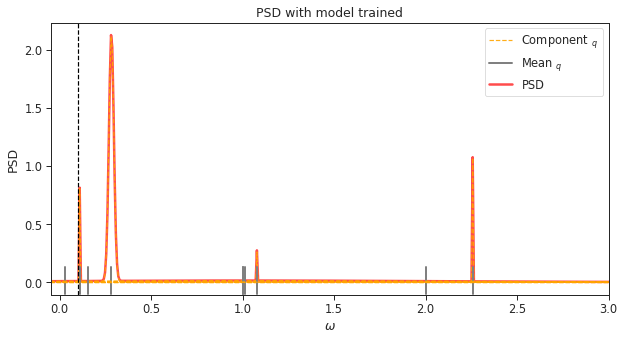

In [8]:
%%time 
model.train(method='L-BFGS-B', maxiter=3000, disp=True, learning_rate=0.001)

mogptk.plot_psd(model, title='PSD with model trained')
plt.axvline(x=1/10, linestyle='--', c='k')
plt.xlim(-0.05, 3);

__Lastly we predict in the test set__

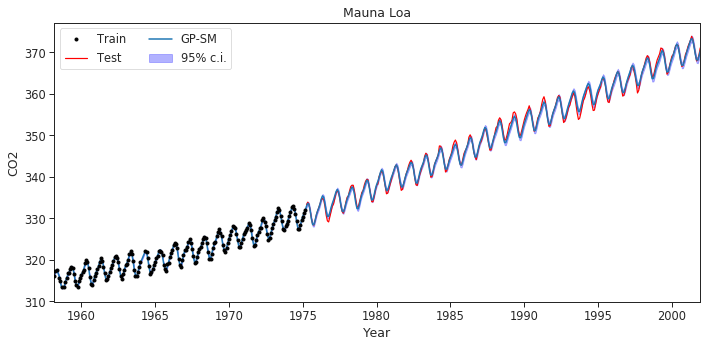

In [9]:
# prediction
x_pred = {0:x[:, np.newaxis]}
x_pred, y_pred, y_var = model.predict(x_pred)

# plot
plt.plot(x[:stop], trend[:stop] + y[:stop], '.k', label='Train', ms=6, zorder=3)
plt.plot(x[stop:], trend[stop:] + y[stop:], '-r', label='Test')
plt.plot(x_pred[0], trend + y_pred[0], lw=1.5, zorder=2, label='GP-SM')
plt.fill_between(x_pred[0].reshape(-1),
                 trend + y_pred[0] + 2 * np.sqrt(y_var[0]),
                 trend + y_pred[0] - 2 * np.sqrt(y_var[0]),
                 color='b',
                 alpha=0.3,
                 zorder=1,
                 label='95% c.i.')
plt.legend(ncol=2)
plt.title('Mauna Loa')
plt.xlabel('Year')
plt.ylabel('CO2')
plt.xlim(x[0], x[-1])
plt.tight_layout();

# Air Quality MOGP

Experiment on multioutput ussing the mogptk toolbox.

The dataset hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device.

The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses.

We will use the columns: $1, 3, 4, 6, 8$.
Where 200 hours of measurements were used ($\approx 8.3$ days), starting from the 12th day.

2. __CO(GT)__ True hourly averaged concentration CO in mg/m^3 (reference analyzer)
3. __PT08.S1(CO)__ PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)
4. __NMHC(GT)__ True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
5. __C6H6(GT)__ True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)
6. __PT08.S2(NMHC)__ PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)
7. __NOx(GT)__ True hourly averaged NOx concentration in ppb (reference analyzer)
8. __PT08.S4(NO2)__ PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
9. __NO2(GT)__ True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)
10. __PT08.S4(NO2)__ PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
11. __PT08.S5(O3)__ PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)
12. __T__ Temperature in Â°C
13. __RH__ Relative Humidity (%)
14. __AH__ AH Absolute Humidity 

__Load and Pre-processing__

In [10]:
# load
df = pd.read_csv('data/AirQualityUCI.csv', delimiter=';')

# last 2 columns are only nans
df = df.iloc[:, :-2]

# drop the rows with nan values
df.dropna(inplace=True)

# First 2 columns are date and time, we convert it to a single column with datetime format
dates = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')

# create column with datetime values
df['timedate'] = dates

# define a initial date to compare all other to
ini_date = pd.Timestamp('2004-03-10 00:00:00.0')

# get elapsed hours
df['time'] = (dates - ini_date) / pd.Timedelta(hours=1)

# drop useless columns
df.drop(columns=['Time', 'Date'], inplace=True)

df.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,timedate,time
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-03-10 18:00:00,18.0
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-03-10 19:00:00,19.0
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-03-10 20:00:00,20.0
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-03-10 21:00:00,21.0
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-03-10 22:00:00,22.0


We check the number of missing values per column, registered as -200 (minimun value of the sensor)

In [11]:
(df == -200).sum(0)

CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
timedate            0
time                0
dtype: int64

## Data to use

* As outputs we will use the ground thruth of: CO, NMHC, C6H6, NOx, NO2.
* Only time is used as input.

For this we will use the mogptk.Data class, which allows to use the different models in the toolbox.

In [12]:
# we use the first 200 rows, the first 3 days
n_experiment = 200
ini_t = 300
df2 = df.iloc[ini_t:n_experiment + ini_t]

In [13]:
# columns to use
cols = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']

# class for storing data
data = mogptk.Data()

for i, c in enumerate(cols):
    # index of non-missing values
    idx = (df2[c] != -200)
    
    print('Channel {} with {} non-missing values'.format(c, idx.sum()))
    
    # add data to the model
    x = df2['time'][idx].values
    y = np.log(df2[c][idx].values)
    
    data.add(x, y)

print('Points per channel:', data.get_channel_sizes())

Channel CO(GT) with 196 non-missing values
Channel NMHC(GT) with 200 non-missing values
Channel C6H6(GT) with 200 non-missing values
Channel NOx(GT) with 192 non-missing values
Channel NO2(GT) with 192 non-missing values
Points per channel: [196, 200, 200, 192, 192]


__Remove random portions of the data to simulate sensor failure__

In [14]:
# randomly sample from the data
for i in range(5):
    data.remove_randomly(channel=i, pct=0.7)

# drop chunks to simulate sensor failure
data.remove_range(0, 425, 460)
data.remove_range(1, 480, None)
data.remove_range(2, 480, None)
data.remove_range(3, 480, None)
data.remove_range(4, None, 350)

__Function for plotting the experiment__

In [15]:
def plot_air_experiment(x_train=None,
                        y_train=None,
                        x_all=None,
                        y_all=None,
                        x_pred=None,
                        y_pred=None,
                        var_pred=None,
                        ylims=None,
                        cols=cols,
                        title=''):
    """
    5x1 Plot for the Air quality experiment
    """
    if ylims is None:
        ylims = [(-1, 7), (-60, 900), (-5, 32), (-50, 380), (10, 170)]
        
    f, axarray = plt.subplots(5, 1, sharex=True, figsize=(12, 10))

    for i in range(5):
        # plot post mean
        if (x_pred is not None) & (y_pred is not None):
            axarray[i].plot(x_pred[i] ,y_pred[i], label='Post.Mean', c=sns.color_palette()[i])
            
        # error bars
        if (x_pred is not None) & (y_pred is not None) & (var_pred is not None):
            axarray[i].fill_between(x_pred[i].reshape(-1),
                                    y_pred[i] + 2 * np.sqrt(var_pred[i]),
                                    y_pred[i] - 2 * np.sqrt(var_pred[i]),
                                    alpha=0.3,
                                    label='95% c.i.',
                                    color=sns.color_palette()[i]
                                   )
        # plot trainning points
        if (x_train is not None) & (y_train is not None):
            axarray[i].plot(x_train[i], y_train[i], '.k', ms=9, label='Training points')
            
        # plot ground truth will all data
        if (x_all is not None) & (y_all is not None):
            axarray[i].plot(x_all[i], y_all[i], '--k', label='All data', alpha=0.6)

        axarray[i].set_ylabel('Log ' + cols[i][:-4])
        axarray[i].set_ylim(ylims[i])

    plt.legend(fontsize=12, ncol=4, bbox_to_anchor=(0.35, 5.65, 0.5, 0.5))
    plt.xlabel('Hours')
    plt.xlim(df2['time'].values[0] - 1, df2['time'].values[-1] + 1)
    plt.suptitle(title, y=0.95)

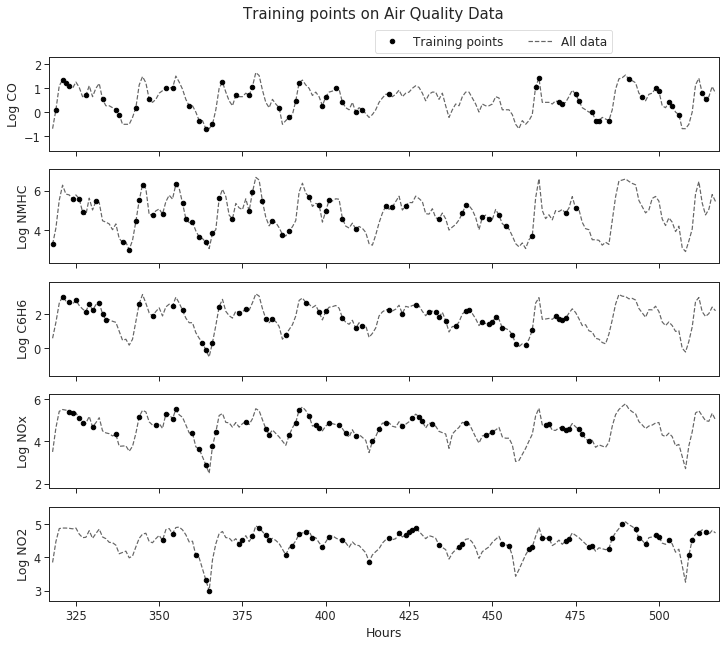

In [16]:
ylims = np.log([(2e-1, 10), (10, 1200), (2e-1, 50), (6, 500), (15, 250)])

title='Training points on Air Quality Data'

plot_air_experiment(x_train=data.X,
                    y_train=data.Y,
                    x_all=data.X_all,
                    y_all=data.Y_all,
                    title=title,
                    ylims=ylims)

# 1. Independant GP with SM kernel (IGP)

As a first approach, we model the 5 mesurement as independent Gaussian processes, each one with a Spectral mixture kernel of $Q=5$ components.

In [17]:
# Spectral Mixture kernel
Q = 5 # number of mixtures
D = 1 # input dim

# prediction inputs
x_pred = np.linspace(df2['time'].values[0], df2['time'].values[-1], 500)
x_pred = {0:x_pred[:, np.newaxis]}

mean_list = []
var_list = []

model_list = []

# metric containers
igp_mae = np.zeros(5)
igp_mape = np.zeros(5)
igp_mse = np.zeros(5)

for i in range(5):
    
    data_single = mogptk.Data()
    data_single.add(data.X[i], data.Y[i])
    
    # first get the sm kernel params set
    model = mogptk.SM(data_single, Q=Q)
    model.init_params('random')
    # model.init_params('LS')
    model.train(method='Adam', maxiter=3000, disp=False, tol=1e-30)
    
    # predict
    x, mean, var = model.predict(x_pred)
    
    mean_list.append(mean[0].reshape(-1))
    var_list.append(var[0].reshape(-1))
    
    model_list.append(model)
    
    # ERROR METRICS
    # predict on all data input 
    
    # generate inputs in the same points as the training set
    idx = df2[cols[i]] != -200
    X_pred = {0:(df2['time'][idx].values)[:, np.newaxis]}
    
    x, mean, var = model.predict(X_pred)
    
    idx = data.Y_all[i] != 0
    
    diff = mean[0][idx] - data.Y_all[i][idx]
    
    igp_mae[i] = np.abs(diff).mean()
    igp_mape[i] = (np.abs(diff) / data.Y_all[i][idx] * 100).mean()
    igp_mse[i] = (diff**2).mean()

pd.DataFrame(np.c_[igp_mae, igp_mape, igp_mse], columns=['MAE', 'MAPE', 'MSE'])

,MAE,MAPE,MSE
0,0.359765,32.874563,0.185282
1,0.683183,13.664844,1.069252
2,0.582535,41.676877,0.645737
3,0.771790,16.450306,1.047445
4,0.389479,8.663669,0.344431


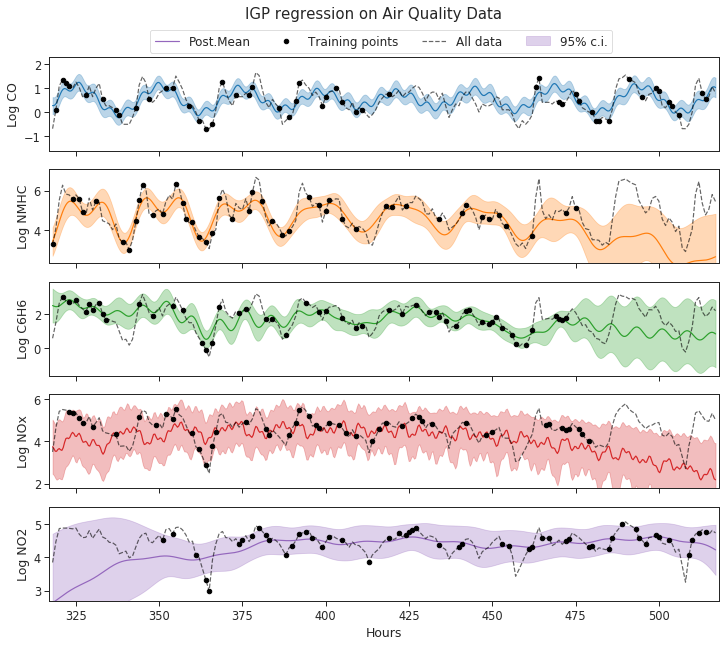

In [18]:
title = 'IGP regression on Air Quality Data'

# duplicate x_pred to satisfy function format
x_pred = np.linspace(df2['time'].values[0], df2['time'].values[-1], 500)
x_pred = [x_pred for i in range(5)]

plot_air_experiment(x_train=data.X,
                    y_train=data.Y,
                    x_all=data.X_all,
                    y_all=data.Y_all,
                    x_pred=x_pred,
                    y_pred=mean_list,
                    var_pred=var_list,
                    title=title,
                    ylims=ylims)
# plt.savefig('output/air_quality_igp.pdf', bbox_inches='tight')

# 2. Multioutput Spectral Mixture (MOSM)

Next we use the multioutput spectral mixture (Parra et al, 2016) to model the measurements

In [19]:
model_mosm = mogptk.MOSM(data, Q=4)
model_mosm.init_params('means')

__Optimice__

In [20]:
%%time
model_mosm.train(method='L-BFGS-B', maxiter=5000, learning_rate=0.001, disp=True, tol=1e-15)

Building...
Optimizing...
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -23.713971
  Number of iterations: 5000
  Number of functions evaluations: 5460
Done
CPU times: user 11min 12s, sys: 53.2 s, total: 12min 5s
Wall time: 8min 47s


__Predict on all hours and plot__

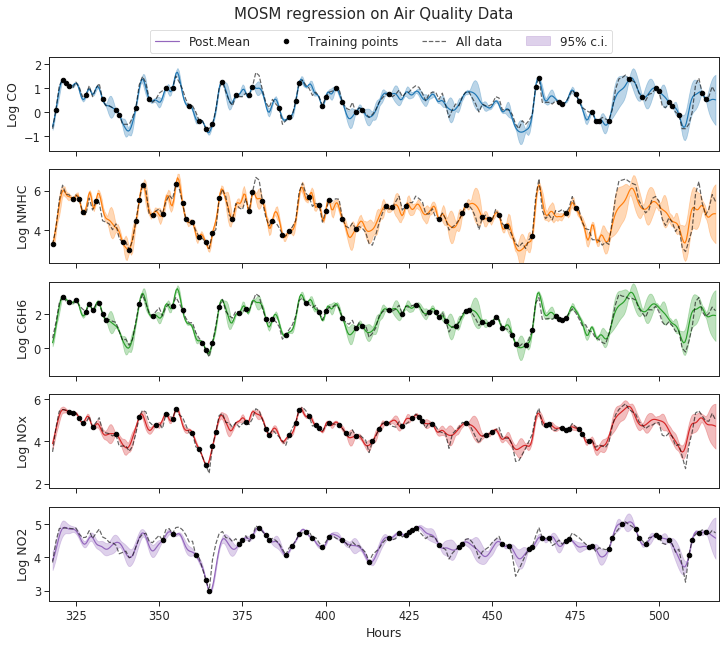

In [21]:
n_res = 500

for i in range(5):
    model_mosm.set_prediction_range(i, df2['time'].values[0], df2['time'].values[-1], n=n_res)

# predict
x_pred, y_pred, var_pred = model_mosm.predict()

# plot
title = 'MOSM regression on Air Quality Data'

plot_air_experiment(x_train=data.X,
                    y_train=data.Y,
                    x_all=data.X_all,
                    y_all=data.Y_all,
                    x_pred=x_pred,
                    y_pred=y_pred,
                    var_pred=var_pred,
                    title=title,
                    ylims=ylims
                   )
# plt.savefig('output/air_quality_mosm.pdf', bbox_inches='tight')

### Get error metrics per channel

* Mean absolute error per channel (MAE)
* Mean absolute percentual error per channel (MAPE)
* Mean squared error per channel (MSE)

In [22]:
# convert data to dict
x_pred = {i:array for i, array in enumerate(data.X_all)}

# predict
x_pred, y_pred, var_pred = model_mosm.predict(x_pred)

# obtain erros
mosm_mae = np.zeros(5)
mosm_mape = np.zeros(5)
mosm_mse = np.zeros(5)

# errors per channel
for i in range(5):
    idx = data.Y_all[i] != 0
    mosm_mae[i] = np.abs(data.Y_all[i] - y_pred[i]).mean() # MAE
    mosm_mape[i] = np.abs((data.Y_all[i][idx] - y_pred[i][idx]) / data.Y_all[i][idx] * 100).mean() # MAPE
    mosm_mse[i] = ((data.Y_all[i] - y_pred[i])**2).mean() # MSE
    
pd.DataFrame(np.c_[mosm_mae, mosm_mape, mosm_mse], columns=['MAE', 'MAPE', 'MSE'])

,MAE,MAPE,MSE
0,0.126660,27.906117,0.039744
1,0.245111,5.173751,0.137907
2,0.169857,14.916118,0.065583
3,0.146740,3.435633,0.050310
4,0.108717,2.470760,0.029517


# 3. Cross Spectral Mixture (CSM)

Then we use the cross spectral mixture kernel (Ulrich et al, 2015)

In [23]:
model_csm = mogptk.CSM(data, Q=4)
model_csm.init_params()

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -69.708209
  Number of iterations: 137
  Number of functions evaluations: 189
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -51.958952
  Number of iterations: 273
  Number of functions evaluations: 371
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -42.024610
  Number of iterations: 64
  Number of functions evaluations: 94
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -72.815528
  Number of iterations: 134
  Number of functions evaluations: 181
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -100.262229
  Number of iterations: 32
  Number of 

In [24]:
model_csm.train(method='L-BFGS-B', maxiter=5000, learning_rate=0.001, tol=1e-15, disp=True)

Building...
Optimizing...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 47.335986
  Number of iterations: 442
  Number of functions evaluations: 485
Done


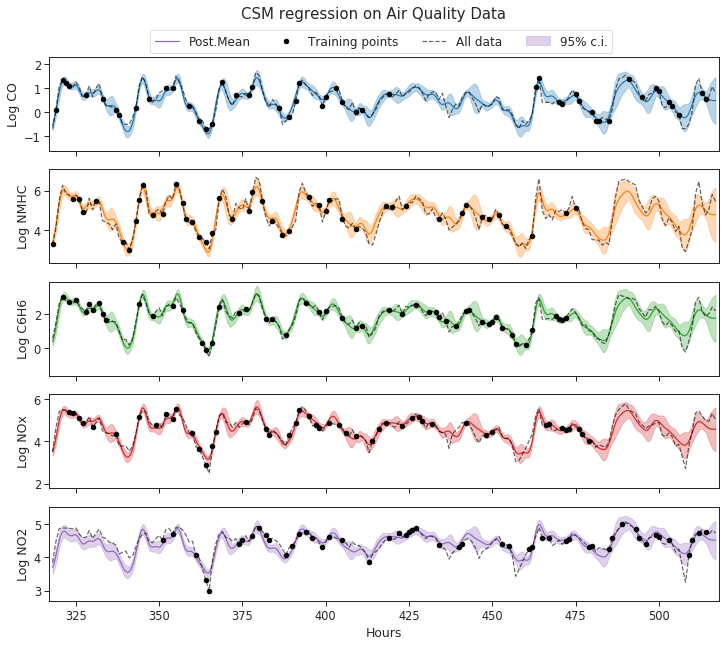

In [25]:
n_res = 500
for i in range(5):
    model_csm.set_prediction_range(i, df2['time'].values[0], df2['time'].values[-1], n=n_res)

# predict
x_pred, y_pred, var_pred = model_csm.predict()

# plot
title = 'CSM regression on Air Quality Data'

plot_air_experiment(x_train=data.X,
                    y_train=data.Y,
                    x_all=data.X_all,
                    y_all=data.Y_all,
                    x_pred=x_pred,
                    y_pred=y_pred,
                    var_pred=var_pred,
                    title=title,
                    ylims=ylims
                   )
# plt.savefig('output/air_quality_csm.pdf', bbox_inches='tight')

In [26]:
# convert data to dict
x_pred = {i:array for i, array in enumerate(data.X_all)}

# predict
x_pred, y_pred, var_pred = model_csm.predict(x_pred)

# obtain erros
csm_mae = np.zeros(5)
csm_mape = np.zeros(5)
csm_mse = np.zeros(5)

# errors per channel
for i in range(5):
    idx = data.Y_all[i] != 0
    csm_mae[i] = np.abs(data.Y_all[i] - y_pred[i]).mean() # MAE
    csm_mape[i] = np.abs((data.Y_all[i][idx] - y_pred[i][idx]) / data.Y_all[i][idx] * 100).mean() # MAPE
    csm_mse[i] = ((data.Y_all[i] - y_pred[i])**2).mean() # MSE
    
pd.DataFrame(np.c_[csm_mae, csm_mape, csm_mse], columns=['MAE', 'MAPE', 'MSE'])

,MAE,MAPE,MSE
0,0.133565,32.721930,0.034361
1,0.261529,5.612750,0.119701
2,0.160159,14.353362,0.057092
3,0.169445,3.911810,0.056568
4,0.145410,3.362605,0.037450


# 4. Spectral Mixture - Linear Model of Corregionalization (SM-LMC)

Lastly we fit the Spectral mixture- linear model of corregionalization (Wilson, 2014)

In [27]:
model_smlmc = mogptk.SM_LMC(data, Q=4)
model_smlmc.init_params()

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -76.723128
  Number of iterations: 137
  Number of functions evaluations: 179
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -41.721297
  Number of iterations: 93
  Number of functions evaluations: 109
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -57.929699
  Number of iterations: 132
  Number of functions evaluations: 163
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -72.765689
  Number of iterations: 30
  Number of functions evaluations: 88
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -102.999353
  Number of iter

In [28]:
model_smlmc.train(method='L-BFGS-B', maxiter=5000, learning_rate=0.001, tol=1e-15, disp=True)

Building...
Optimizing...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 46.776797
  Number of iterations: 636
  Number of functions evaluations: 706
Done


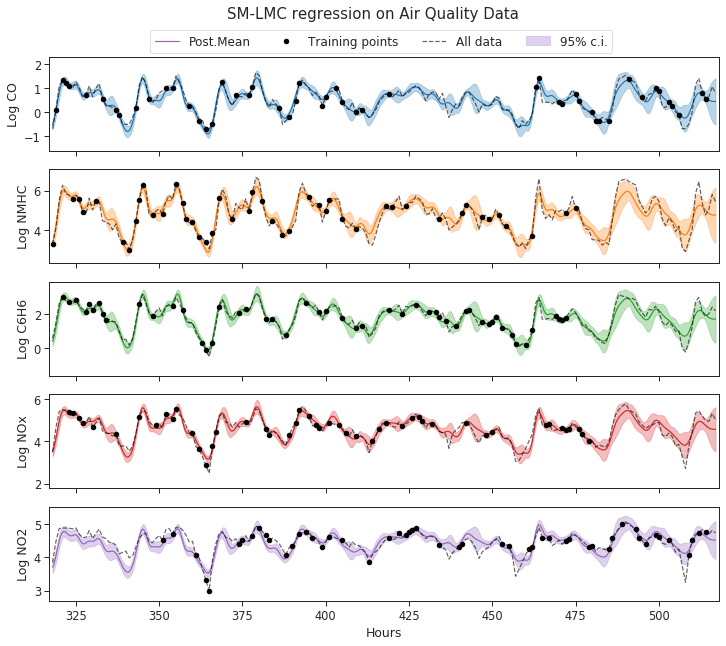

In [29]:
n_res = 500

for i in range(5):
    model_smlmc.set_prediction_range(i, df2['time'].values[0], df2['time'].values[-1], n=n_res)

# predict
x_pred, y_pred, var_pred = model_smlmc.predict()

# pLot
title = 'SM-LMC regression on Air Quality Data'

plot_air_experiment(x_train=data.X,
                    y_train=data.Y,
                    x_all=data.X_all,
                    y_all=data.Y_all,
                    x_pred=x_pred,
                    y_pred=y_pred,
                    var_pred=var_pred,
                    title=title,
                    ylims=ylims)
# plt.savefig('output/air_quality_smlmc.pdf', bbox_inches='tight')

In [30]:
# convert data to dict
x_pred = {i:array for i, array in enumerate(data.X_all)}

# predict
x_pred, y_pred, var_pred = model_csm.predict(x_pred)

# obtain erros
smlmc_mae = np.zeros(5)
smlmc_mape = np.zeros(5)
smlmc_mse = np.zeros(5)

# errors per channel
for i in range(5):
    idx = data.Y_all[i] != 0
    smlmc_mae[i] = np.abs(data.Y_all[i] - y_pred[i]).mean() # MAE
    smlmc_mape[i] = np.abs((data.Y_all[i][idx] - y_pred[i][idx]) / data.Y_all[i][idx] * 100).mean() # MAPE
    smlmc_mse[i] = ((data.Y_all[i] - y_pred[i])**2).mean() # MSE
    
pd.DataFrame(np.c_[smlmc_mae, smlmc_mape, smlmc_mse], columns=['MAE', 'MAPE', 'MSE'])

,MAE,MAPE,MSE
0,0.133565,32.721930,0.034361
1,0.261529,5.612750,0.119701
2,0.160159,14.353362,0.057092
3,0.169445,3.911810,0.056568
4,0.145410,3.362605,0.037450


# 5. Convolutional Gaussian (CONV)

In [31]:
# model_conv = mogptk.CG(data, Q=4)
# model_conv.init_params()

In [32]:
# model_conv.train(method='L-BFGS-B', maxiter=5000, learning_rate=0.001, tol=1e-15)

In [33]:
n_res = 500

for i in range(5):
    model_conv.set_prediction_range(i, df2['time'].values[0], df2['time'].values[-1], n=n_res)

# predict
x_pred, y_pred, var_pred = model_conv.predict()

# pLot
title = 'CONV regression on Air Quality Data'

plot_air_experiment(x_train=data.X,
                    y_train=data.Y,
                    x_all=data.X_all,
                    y_all=data.Y_all,
                    x_pred=x_pred,
                    y_pred=y_pred,
                    var_pred=var_pred,
                    title=title
                   )
# plt.savefig('output/air_quality_conv.pdf', bbox_inches='tight')

NameError: name 'model_conv' is not defined

In [ ]:
# convert data to dict
x_pred = {i:array for i, array in enumerate(data.X_all)}

# predict
x_pred, y_pred, var_pred = model_csm.predict(x_pred)

# obtain erros
conv_mae = np.zeros(5)
conv_mape = np.zeros(5)
conv_mse = np.zeros(5)

# errors per channel
for i in range(5):
    idx = df2[c] != -200
    conv_mae[i] = np.abs(data.Y_all[i] - y_pred[i]).mean() # MAE
    conv_mape[i] = np.abs((data.Y_all[i] - y_pred[i]) / data.Y_all[i] * 100).mean() # MAPE
    conv_mse[i] = ((data.Y_all[i] - y_pred[i])**2).mean() # MSE
    
pd.DataFrame(np.c_[conv_mae, conv_mape, conv_mse], columns=['MAE', 'MAPE', 'MSE'])

# 6. Comparison between models

We compare all the models taking the average MAPE across al channels

In [34]:
pd.DataFrame(np.r_[igp_mape.mean(), mosm_mape.mean(), csm_mape.mean(), smlmc_mape.mean()],
             index=['IGP', 'MOSM', 'CSM', 'SM-LMC'],
             columns=['Mean MAPE'])

,Mean MAPE
IGP,22.666052
MOSM,10.780476
CSM,11.992491
SM-LMC,11.992491
